In [2]:
%matplotlib inline

In [3]:
import sys
sys.path.append('lib_geodezyx_toolbox_py3')
import geoclass as gcls
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os
from collections import defaultdict
import itertools
from glob import glob
from tqdm import tqdm

In [4]:
root_path = '/data_hdd/data/geoxautumschool2018/products'
directory = 'wk1998'
file = '19982.sp3'

acs = ['com', 'grm', 'tum', 'wum', 'jam', 'gbm']
paths = [x + file for x in acs]

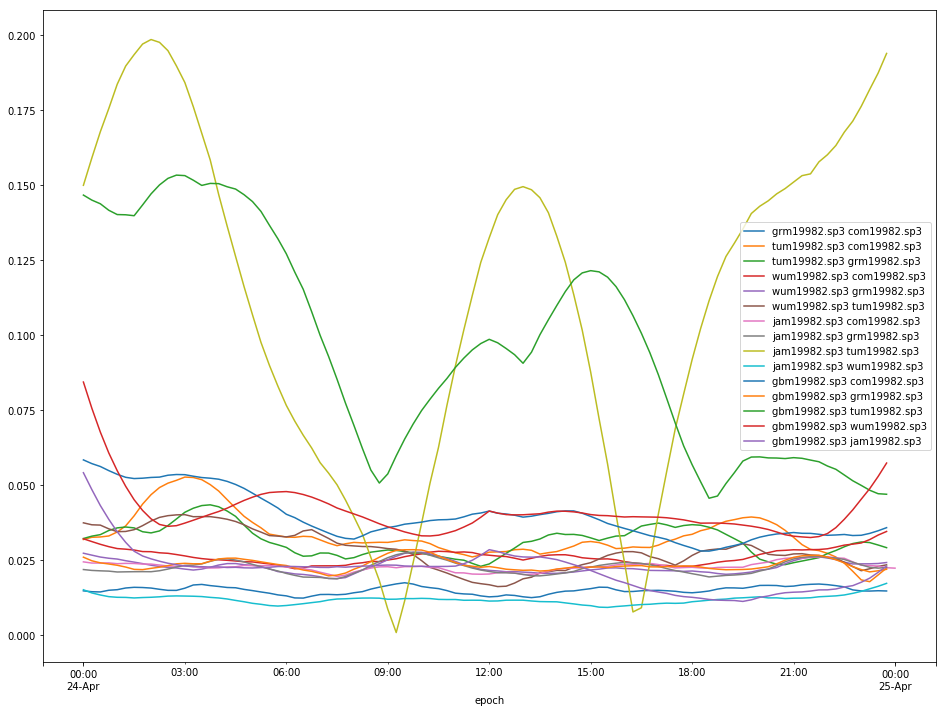

In [116]:
data = {}
sats = set()
for path in paths:
    data[path] = gcls.read_sp3(os.path.join(root_path, directory, path))
    [sats.add(x) for x in data[path]['sat']]

diffs = defaultdict(dict)
sats = list(sats)

fig, ax = plt.subplots(figsize=(16, 12))

for i1 in range(len(paths)):
    for i2 in range(i1):
        p1 = paths[i1]
        p2 = paths[i2]
        try:
            diffs[p1][p2] = gcls.compar_orbit(data[p1], data[p2], sats_used_list=sats)
            diffs[p1][p2]['var_r'] = np.abs(diffs[p1][p2]['dr'])
    
            diffs[p1][p2].groupby('epoch').mean().plot(y='var_r', ax=ax, label=f'{p1} {p2}')
        except:
            pass


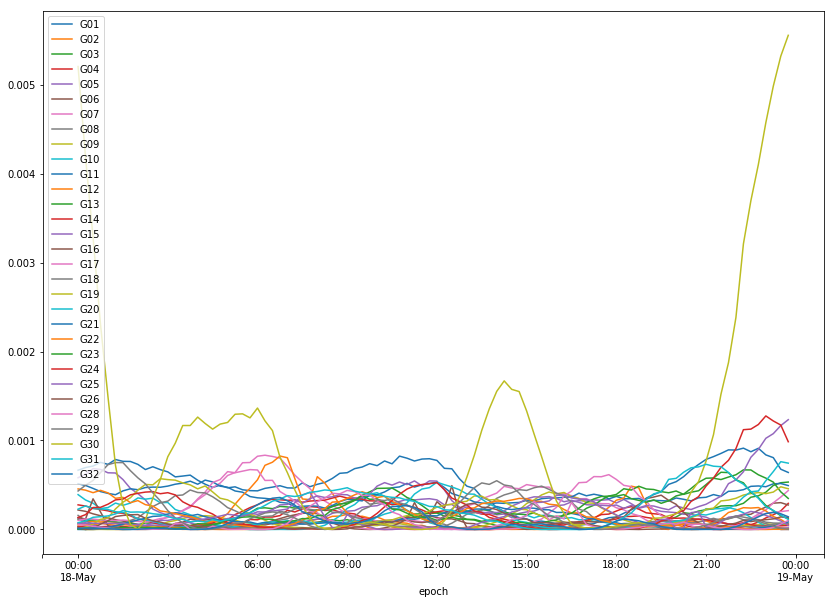

In [78]:
fig, ax = plt.subplots(figsize=(14,10))

for label, df in diff.groupby('sat'):
    df.plot(y='var_r', ax=ax, label=label)

In [108]:
sat = [f'G{i:02d}' for i in range(1,33)]
ac1 = 'jam'
ac2 = 'gbm'

df_ac1 = None
df_ac2 = None

for wk in tqdm(sorted(glob(f'{root_path}/*'))):
    files1 = sorted(glob(f'{wk}/{ac1}*.sp3'))
    files2 = sorted(glob(f'{wk}/{ac2}*.sp3'))
    if files1 and files2:
        for file in files1:
            tmp_ac1 = gcls.read_sp3(file)
            tmp_ac1 = tmp_ac1[tmp_ac1['sat'].isin(sat)]
            if df_ac1 is None:
                df_ac1 = tmp_ac1
            else:
                df_ac1 = df_ac1.append(tmp_ac1)
        for file in files2:
            tmp_ac2 = gcls.read_sp3(file)
            tmp_ac2 = tmp_ac2[tmp_ac2['sat'].isin(sat)]
            if df_ac2 is None:
                df_ac2 = tmp_ac2
            else:
                df_ac2 = df_ac2.append(tmp_ac2)


100%|██████████| 341/341 [01:39<00:00,  3.44it/s]


In [109]:
df = pd.merge(df_ac1, df_ac2, how='inner', on=['epoch', 'sat', 'const', 'sv'], suffixes=('1', '2'))
df.sort_values('epoch');

In [110]:
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Dense, Input, Add, Dropout
from keras import optimizers
from keras import losses
from sklearn.metrics import mean_squared_error

In [111]:
train_dev_test = (0.6, 0.1, 0.3)
df_train, df_dev_test = train_test_split(df, train_size=train_dev_test[0], test_size=train_dev_test[1]+train_dev_test[2], shuffle=False)
df_dev, df_test = train_test_split(df_dev_test, train_size=train_dev_test[1], test_size=train_dev_test[2], shuffle=False)

print(f'{len(df_train)} {len(df_dev)} {len(df_test)}')

train_x = df_train[['x1', 'y1', 'z1']].values
train_y = df_train[['x2', 'y2', 'z2']].values - train_x
dev_x = df_dev[['x1', 'y1', 'z1']].values
dev_y = df_dev[['x2', 'y2', 'z2']].values - dev_x
test_x = df_test[['x1', 'y1', 'z1']].values
test_y = df_test[['x2', 'y2', 'z2']].values - test_x

train_x=train_x[np.max(np.abs(train_y), axis=1)<0.001]
train_y=train_y[np.max(np.abs(train_y), axis=1)<0.001]
dev_x=dev_x[np.max(np.abs(dev_y), axis=1)<0.001]
dev_y=dev_y[np.max(np.abs(dev_y), axis=1)<0.001]
test_x=test_x[np.max(np.abs(test_y), axis=1)<0.001]
test_y=test_y[np.max(np.abs(test_y), axis=1)<0.001]

1914232 127615 382847


In [112]:
## Extremly simply network
dropout = 0.8

i = Input(shape=(3,))
x = Dense(100, kernel_initializer='glorot_normal', bias_initializer='zeros', activation='tanh')(i)
x = Dropout(dropout)(x)
x = Dense(50, kernel_initializer='glorot_normal', bias_initializer='zeros', activation='tanh')(x)
x = Dropout(dropout)(x)
x = Dense(20, kernel_initializer='glorot_normal', bias_initializer='zeros', activation='tanh')(x)
x = Dropout(dropout)(x)
x = Dense(3, kernel_initializer='zeros', bias_initializer='zeros', activation='tanh')(x)
m = Model(inputs=i, outputs=x)

In [113]:
adam = optimizers.Adam(lr=1e-4, decay=0.01)
loss = losses.mean_squared_error
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

m.compile(optimizer=adam, loss=loss)
m.fit(x=train_x, y=train_y, validation_data=(dev_x, dev_y), batch_size=1024, epochs=50, callbacks=[es])

Train on 1906076 samples, validate on 127383 samples
Epoch 1/50
1906076/1906076 [==============================] - 5s 3us/step - loss: 7.0441e-10 - val_loss: 2.8979e-10
Epoch 2/50
1906076/1906076 [==============================] - 4s 2us/step - loss: 3.8878e-10 - val_loss: 2.8443e-10
Epoch 3/50
1906076/1906076 [==============================] - 4s 2us/step - loss: 3.8713e-10 - val_loss: 2.9572e-10
Epoch 4/50
1906076/1906076 [==============================] - 4s 2us/step - loss: 3.8468e-10 - val_loss: 2.8817e-10
Epoch 5/50
1906076/1906076 [==============================] - 4s 2us/step - loss: 3.8289e-10 - val_loss: 2.9363e-10
Epoch 6/50
1906076/1906076 [==============================] - 4s 2us/step - loss: 3.8168e-10 - val_loss: 2.8944e-10
Epoch 7/50
1906076/1906076 [==============================] - 4s 2us/step - loss: 3.8068e-10 - val_loss: 2.8840e-10
Epoch 8/50
1906076/1906076 [==============================] - 4s 2us/step - loss: 3.7981e-10 - val_loss: 2.9206e-10
Epoch 9/50
1906076/

In [114]:
train_pred = m.predict(train_x)
print('Train:')
print(np.mean((train_pred-train_y)**2))
print(np.mean((train_pred)**2))
print(np.mean((train_y)**2))

dev_pred = m.predict(dev_x)
print('Dev:')
print(np.mean((dev_pred-dev_y)**2))
print(np.mean((dev_pred)**2))
print(np.mean((dev_y)**2))

test_pred = m.predict(test_x)
print('Test:')
print(np.mean((test_pred-test_y)**2))
print(np.mean((test_pred)**2))
print(np.mean((test_y)**2))

Train:
3.6020143162937346e-10
1.4428706e-11
3.886621232699673e-10
Dev:
2.84431959599057e-10
1.4434677e-11
3.012030884035198e-10
Test:
3.1469870321410044e-10
1.4431456e-11
3.343884750789304e-10


In [115]:
dev_pred[:10]

array([[ 3.4882200e-06,  1.6641089e-06,  6.6073321e-06],
       [ 3.1021557e-07, -1.2103351e-07,  7.0860742e-06],
       [ 5.4444181e-06,  2.8553811e-06,  5.1462280e-06],
       [-2.1514825e-07,  9.1870652e-07,  4.4554595e-06],
       [ 1.7946093e-07,  1.3011212e-06,  8.3035911e-06],
       [ 4.5411605e-07,  8.3383833e-07,  3.6544686e-06],
       [ 1.1161317e-06,  1.6633677e-06,  6.0008406e-06],
       [ 2.9401019e-06,  1.7923647e-06,  6.9907278e-06],
       [ 1.9332331e-06,  7.4843263e-07,  5.7105958e-06],
       [ 4.6773207e-06,  1.8956318e-06,  3.3408544e-06]], dtype=float32)

In [116]:
dev_y[:10]

array([[ 1.99999995e-05, -2.09999998e-05,  7.99999998e-06],
       [ 1.20000004e-05,  1.20000004e-05,  6.00000203e-06],
       [-2.60000000e-05, -2.30000005e-05,  1.99999995e-05],
       [-3.59999976e-05, -1.10000001e-05, -1.39999993e-05],
       [ 1.99999704e-06,  3.00000011e-06,  2.79999986e-05],
       [-3.39999970e-05, -4.00000135e-06, -2.79999999e-05],
       [ 3.89999987e-05,  1.50000014e-05,  1.70000003e-05],
       [ 2.89999989e-05, -7.99999998e-06,  0.00000000e+00],
       [-4.99999987e-06,  0.00000000e+00,  1.30000003e-05],
       [-2.59999997e-05,  1.30000008e-05, -8.99999941e-06]])